In [2]:
%matplotlib inline 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KDTree
from scipy.spatial import ConvexHull

import pandas_datareader.data as web
from datetime import datetime
import pytz

In [4]:
from pandas.plotting import scatter_matrix

In [46]:
np.random.seed(0)
Coins = ['BTC-USD','ETH-USD','DOT-USD','TSLA','GOLD']

In [47]:
#load data
#year, month, day, hour, minute, second, microsecond
start = datetime(2018, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2022, 1, 1, 0, 0, 0, 0, pytz.utc) 

In [13]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 5.2 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [48]:
data = pd.DataFrame()
series = []
for ticker in Coins:
    price = web.DataReader(ticker, 'yahoo', start, end)
    series.append(price['Close'])

In [49]:
data = pd.concat(series, axis=1)
data.columns = Coins
data = data.dropna()
data.head()

,BTC-USD,ETH-USD,DOT-USD,TSLA,GOLD
Date,,,,,
2020-08-20,11878.372070,416.439789,2.900080,400.365997,29.950001
2020-08-21,11592.489258,389.126343,2.875028,409.996002,29.309999
2020-08-24,11774.595703,408.144196,4.602614,402.839996,28.969999
2020-08-25,11366.134766,384.001038,5.523393,404.667999,28.750000
2020-08-26,11488.363281,386.466125,6.081716,430.634003,29.370001


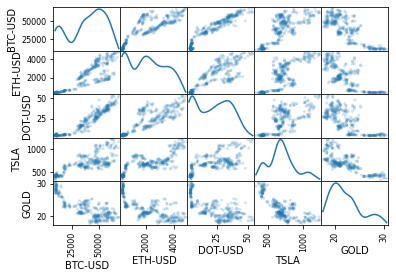

In [50]:
scatter_matrix(data, alpha=0.2, diagonal='kde')
plt.show()

In [51]:
#get current portfolio
cash = 10000
num_assets = np.size(Coins)
cur_value = (1e4-5e3)*np.random.rand(num_assets,1) + 5e3        
tot_value = np.sum(cur_value)
weights = cur_value.ravel()/float(tot_value)

In [52]:
#compute portfolio risk
Sigma = data.cov().values
Corr = data.corr().values        
volatility = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))

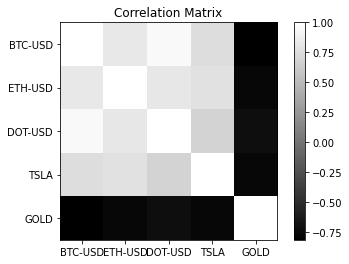

In [53]:
plt.figure()
plt.title('Correlation Matrix')        
plt.imshow(Corr, cmap='gray')
plt.xticks(range(len(Coins)),data.columns)
plt.yticks(range(len(Coins)),data.columns)    
plt.colorbar()
plt.show()

In [54]:
#generate random portfolio weights
num_trials = 1000
W = np.random.rand(num_trials, np.size(weights))    
W = W/np.sum(W,axis=1).reshape(num_trials,1)  #normalize
    
pv = np.zeros(num_trials)   #portoflio value  w'v
ps = np.zeros(num_trials)   #portfolio sigma: sqrt(w'Sw)

In [57]:
avg_price = data.mean().values
adj_price = avg_price
    
for i in range(num_trials):
    pv[i] = np.sum(adj_price * W[i,:])
    ps[i] = np.sqrt(np.dot(W[i,:].T, np.dot(Sigma, W[i,:])))
    
points = np.vstack((ps,pv)).T
hull = ConvexHull(points)

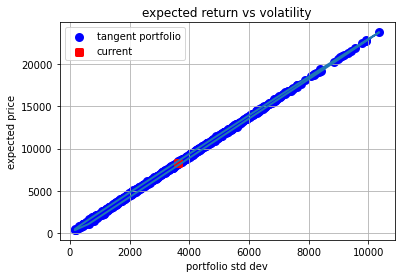

In [58]:
plt.figure()
plt.scatter(ps, pv, marker='o', color='b', linewidth = '3.0', label = 'tangent portfolio')
plt.scatter(volatility, np.sum(adj_price * weights), marker = 's', color = 'r', linewidth = '3.0', label = 'current')
plt.plot(points[hull.vertices,0], points[hull.vertices,1], linewidth = '2.0')    
plt.title('expected return vs volatility')
plt.ylabel('expected price')
plt.xlabel('portfolio std dev')
plt.legend()
plt.grid(True)
plt.show()

In [59]:
#query for nearest neighbor portfolio
knn = 5    
kdt = KDTree(points)
query_point = np.array([2, 115]).reshape(1,-1)
kdt_dist, kdt_idx = kdt.query(query_point,k=knn)
print ("top-%d closest to query portfolios:" %knn)
print ("values: ", pv[kdt_idx.ravel()])
print ("sigmas: ", ps[kdt_idx.ravel()])

top-5 closest to query portfolios:
values:  [365.65678582 377.16872689 501.61291241 560.3578218  572.38738261]
sigmas:  [170.51695717 190.87877401 183.58690872 272.729205   266.98101209]
